In [160]:
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import pandas as pd
import numpy as np
import glob
import os
import copy
import sep

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams

import splusdata

import kungpao
from kungpao.io import save_to_fits
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from kungpao.isophote import galSBP, bmodel, plotting
from kungpao import imtools, query, sbp

# Convolution kernel I used for detecting objects on the image
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

# Increase the pixel stack for large image
sep.set_extract_pixstack(100000)

import warnings
warnings.filterwarnings("ignore")

bands = [ 'R', 'G', 'I', 'U', 'Z', 'F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861' ]
conn = splusdata.connect ( 'juanpablocalderon', '******' ) 

output_dir = 'NGC1379/'
downloaded_fits = 'downloaded_fits/'

You have access to internal data


In [180]:
target = 'NGC 1379'
field = 'SPLUS-s27s34'
coord = SkyCoord.from_name ( target )
ra = coord.ra.deg
dec = coord.dec.deg

for band in bands:
        image = downloaded_fits + field + '/' + field + '_' + band + '_swp.fits'

        s = 1000 * u.pixel

        # Load the image and the WCS
        hdu = fits.open( image )[0]
        wcs = WCS ( hdu.header )

        # Make the cutout, including the WCS
        cutout = Cutout2D ( hdu.data, position = coord, size = s, wcs = wcs )

        # Put the cutout image in the FITS HDU
        hdu.data = cutout.data

        # Update the FITS header with the cutout WCS
        hdu.header.update ( cutout.wcs.to_header() )

        # Write the cutout to a new FITS file
        cutout_filename =  downloaded_fits + target.replace(' ', '') + '_' + band + '-cutout.fits'
        print ( "[*] Cutting: " + cutout_filename )
        hdu.writeto ( cutout_filename, overwrite = True )

[*] Cutting: downloaded_fits/NGC1379_F861-cutout.fits


In [163]:
data = None
for band in ['G', 'Z', 'I', 'R']: 
    f =  fits.open(downloaded_fits + target.replace(' ', '') + '_' + band + '-cutout.fits')
    if data is None:
        data = f[0].data
    else:
        data += f[0].data

    if band == 'R':
        f[0].data = data
        print ( "[*] Saving: " + downloaded_fits + target.replace(' ','') + '_detection.fits' )
        f.writeto(downloaded_fits + target.replace(' ','') + '_detection.fits', overwrite=True)

[*] Saving: downloaded_fits/NGC1379_detection.fits


In [165]:
img_detection = output_dir + 'NGC1379_detection.fits'

hdr = fits.open(img_detection)[0].header
img = fits.open(img_detection)[0].data
wcs = WCS(hdr)

# For running sep
img = img.byteswap().newbyteorder()

img_w, img_h = img.shape
print (img_w, img_h)

1000 1000


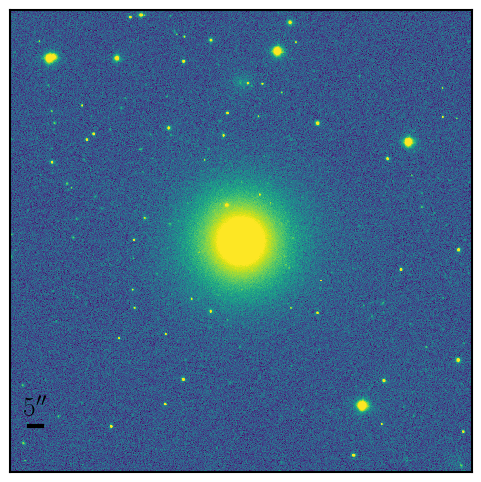

In [166]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

_ = display_single ( img, ax = ax1, contrast = 0.2, scale_bar_y_offset = 1.2, scale_bar_color = 'k' )

In [169]:
gaia_stars, msk_star = imtools.gaia_star_mask ( img, wcs, pix = 0.55, mask_a = 694.7, mask_b = 4, 
                                               size_buffer = 1.8, gaia_bright = 24.0, factor_b = 1.4, factor_f = 1.9 )
print ( len(gaia_stars) )

50


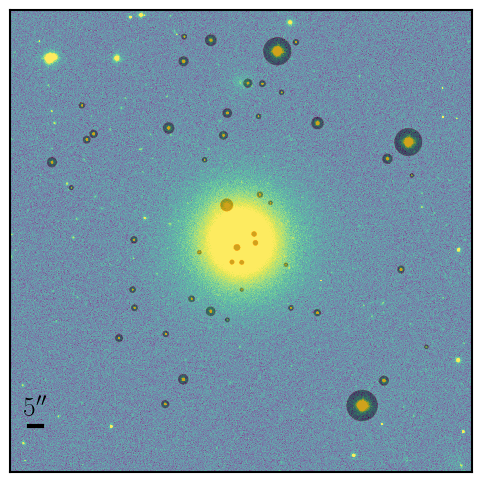

In [170]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

_ = display_single(img, ax=ax1, scale_bar_y_offset=1.2, scale_bar_color='k')

# Overplot the mask
_ = ax1.imshow(msk_star, origin='lower', cmap='Reds', alpha=0.3)

In [171]:
np.nanmedian(img * (~msk_star.astype(bool))) #, weights=~msk_star.astype(bool))

0.07328062

In [172]:
img_fits = output_dir + 'NGC1379_img.fits'
msk_fits = output_dir + 'NGC1379_msk.fits'

_ = save_to_fits(img, img_fits)
_ = save_to_fits(msk_star.astype('uint8'), msk_fits)

img_masked_fits = output_dir + 'NGC1379_masked.fits'
img_masked = np.multiply(img, (~msk_star.astype(bool)))
_ = save_to_fits(img_masked, img_masked_fits, header = hdr)

print ( "[*] Original image: " + img_fits )
print ( "[*] Maks: " + msk_fits )
print ( "[*] Mask applied to the image: " + img_masked_fits )

[*] Original image: NGC1379/NGC1379_img.fits
[*] Maks: NGC1379/NGC1379_msk.fits
[*] Mask applied to the image: NGC1379/NGC1379_masked.fits


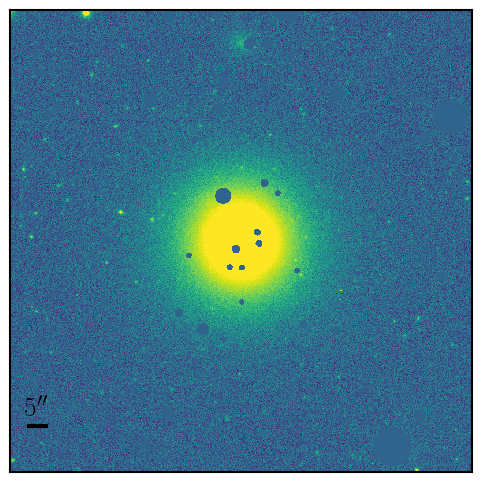

In [157]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

#~msk_star.astype(bool)
_ = display_single(np.multiply(img, (~msk_star.astype(bool))), ax=ax1, scale_bar_y_offset=1.2, scale_bar_color='k')

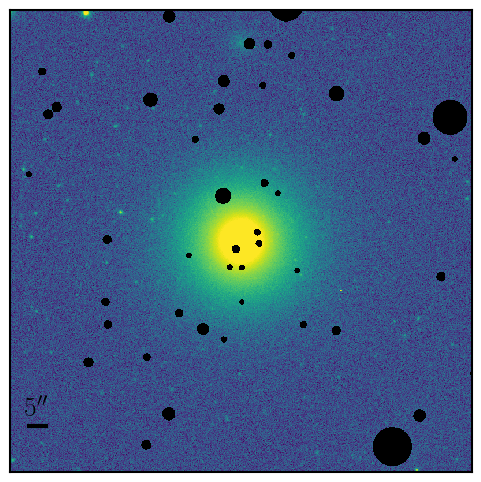

In [120]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

_ = display_single ( img, ax = ax1, contrast = 0.2, scale_bar_y_offset = 1.2, scale_bar_color = 'k' )